In [1]:
import os
from typing import List
import tensorflow as tf
import cv2


2024-02-22 19:59:43.493596: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-22 19:59:43.519278: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 19:59:43.519298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 19:59:43.520229: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 19:59:43.524939: I tensorflow/core/platform/cpu_feature_guar

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
tf.config.list_physical_devices('GPU')

2024-02-22 19:59:44.567511: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 19:59:44.590488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 19:59:44.590632: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()  # close the video file

    mean = tf.math.reduce_mean(frames)  # compute the mean
    std = tf.math.reduce_std(tf.cast(frames, tf.float32)) # compute the standard 
    return tf.cast((frames - mean), tf.float32) / std # normalize to zero mean and 

In [4]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' '] (size =28)


2024-02-22 19:59:44.609492: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 19:59:44.609636: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 19:59:44.609732: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
def load_alignments(path:str) ->  List[str]:
    with open(path, 'r') as f:
        alignments = f.readlines()
    tokens =[]
    for line in alignments:
        line = line.split()
        if line[2] !='sil':
            tokens=[*tokens,' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:] 
def init_alignments(path:str) -> dict[str:List[str]]: 
    alignments = {}
    if not os.path.exists(path): 
        raise FileNotFoundError(f'{path} does not exist')
    for file in os.listdir(path): 
        if file.endswith('.align'): 
            with open(os.path.join(path, file), 'r') as f: 
                lines = f.readlines()
            tokens = []
            for line in lines:
                line = line.split()
                if line[2] != 'sil': 
                    tokens = [*tokens,' ',line[2]]
            alignments[file] = char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]
    return alignments
alignments_dict = init_alignments('./data/alignments/s1')
def generate_video_dict(path:str) -> dict[str:List[float]]: 
    video_dict= {}
    if not os.path.exists(path): 
        raise FileNotFoundError(f'{path} does not exist')
    for file in os.listdir(path): 
        if file.endswith('.mpg'): 
            cap = cv2.VideoCapture(os.path.join(path, file))
            frames = []
            for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):  
                ret, frame = cap.read()
                frame = tf.image.rgb_to_grayscale(frame)
                # frames.append(frame[190:236,80:220,:]) # s1
                frames.append(frame[200:246,100:240,:]) # s10
            cap.release()
            mean = tf.math.reduce_mean(frames)
            std = tf.math.reduce_std(tf.cast(frames, tf.float16))
            video_dict[file] = tf.cast((frames - mean), tf.float16) / std
    return video_dict
video_dict = generate_video_dict('./data/s1')

2024-02-22 19:59:46.158268: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
[mpeg1video @ 0x557123865240] ac-tex damaged at 22 17
[mpeg1video @ 0x557123865240] Warning MVs not available


In [25]:
# def load_data(path:str):
#     file_name = path.split('/')[-1].split('.')[0]
#     video_path=os.path.join('data','s1',f'{file_name}.mpg')
#     alignment_path=os.path.join('data','alignments','s1',f'{file_name}.align')
#     frames=load_video(video_path)
#     alignments=load_alignments(alignment_path)
#     return frames, alignments
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = f'{file_name}.mpg'
    alignment_path = f'{file_name}.align'
    frames = video_dict.get(video_path)
    alignments = alignments_dict.get(alignment_path)
    
    return frames, alignments

In [27]:
test_path = './data/s1/bbbmzn.mpg'
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0] 
frames, alignments = load_data(tf.convert_to_tensor(test_path))
print(tf.strings.reduce_join(num_to_char(alignments)).numpy().decode('utf-8'))

bin blue by m zero now


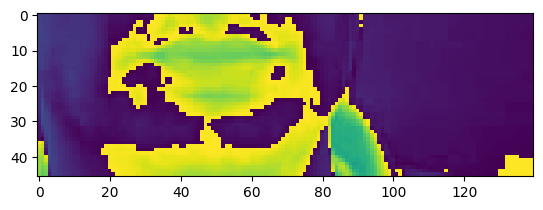

In [28]:
from matplotlib import pyplot as plt 
plt.imshow(frames[12])

In [29]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float16, tf.int64)) # py_function is used to convert a python function to a tensorflow function
    return result

In [30]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')  # list all the files
data = data.shuffle(500, reshuffle_each_iteration=False)   
data = data.map(mappable_function) # 75 frames, 46x140 pixels, 1 channel
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40])) # 75 frames, 46x140 pixels, 1 channel
data = data.prefetch(tf.data.AUTOTUNE) # prefetch the data
# Added for split 
train = data.take(450) 
test = data.skip(450)

In [31]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications import ResNet50

In [32]:
base_model = ResNet50(weights='imagenet',
                      include_top=False, input_shape=(46,140, 3))

# If you wish to Freeze layers
for layer in base_model.layers:
  layer.trainable = True
  
model = Sequential()
model.add(base_model)
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))  # 128 filters, 3x3 kernel input shape is 75 frames, 46x140 pixels, 1 channel 
model.add(Activation('relu'))  # activation function
model.add(MaxPool3D((1,2,2)))  # max pooling

model.add(Conv3D(256, 3, padding='same'))  # 256 filters, 3x3 kernel
model.add(Activation('relu'))  
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))  # flatten the output of the previous layer

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))  # bidirectional LSTM
model.add(Dropout(.5))  # dropout layer

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))  # output layer

In [33]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_6 (Activation)   (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 75, 23, 70, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_7 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_7 (Activation)   (None, 75, 23, 70, 256)   0         
                                                      

In [34]:
frames, alignments = data.as_numpy_iterator().next()

In [35]:
yhat=model.predict(frames)

2024-02-22 20:08:14.899404: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-02-22 20:08:15.080018: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 5s 5s/step


In [37]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssdddd'>

In [41]:
def scheduler(epoch, lr):   # learning rate scheduler
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)  

In [42]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [43]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)


In [44]:
checkpoint_callback = ModelCheckpoint(os.path.join('models_6','checkpoint'), monitor='loss', save_weights_only=True) 

In [45]:
schedule_callback = LearningRateScheduler(scheduler)

In [46]:
model.fit(train, validation_data=test, epochs=60, callbacks=[checkpoint_callback, schedule_callback],batch_size=400)

Epoch 1/60


2024-02-22 20:11:16.401957: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa5d8acc2f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-22 20:11:16.401972: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-02-22 20:11:16.410164: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708632676.462114   32074 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


KeyboardInterrupt: 

In [ ]:
loss_history = model.history.history

In [ ]:
# draw the loss curve
print(loss_history.keys())
plt.plot(loss_history['loss'], label='loss')
plt.plot(loss_history['val_loss'], label='val_loss')
# x label and y label
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Loss Curve for adding resNet50 with datasetS10')
plt.legend(loc='upper right')
filename = 'loss_curve_resNet50_datasetS10_notitle.png'
plt.savefig(filename)      
plt.show()

In [53]:
model.load_weights('models_4/checkpoint')

In [52]:
test_loss= model.evaluate(test)
print(f' adding resNet50 for dataset S10 The Test loss: {test_loss}')
# accuracy
accuracy = 100 - test_loss
print(f' adding resNet50 for dataset S10 The Test accuracy: {accuracy}')
# test on the train data
train_loss= model.evaluate(train)
print(f' adding resNet50 for dataset S10 The Train loss: {train_loss}')

50/50 [==============================] - 3s 54ms/step - loss: 87.9974
 adding resNet50 for dataset S10 The Test loss: 87.99738311767578
 adding resNet50 for dataset S10 The Test accuracy: 12.002616882324219
450/450 [==============================] - 24s 54ms/step - loss: 94.1937
 adding resNet50 for dataset S10 The Train loss: 94.19366455078125


In [61]:
test_data = test.as_numpy_iterator()

In [62]:
sample = test_data.next()

In [63]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 64ms/step


In [64]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green by p six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue with r four please'>]

In [65]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [66]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set gre in eihe soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set bre wit eiwh soon'>]